<a href="https://colab.research.google.com/github/Prer26/ai-workshop/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub


path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_dir   = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_dir  = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

img_size = (224,224)
batch = 32

datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch, class_mode="binary")
val   = datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch, class_mode="binary")
test  = datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch, class_mode="binary")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers,models

model=models.Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history=model.fit(train,epochs=5,validation_data=val)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 620s 4s/step - accuracy: 0.8110 - loss: 0.4019 - val_accuracy: 0.8750 - val_loss: 0.2673
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 629s 4s/step - accuracy: 0.9636 - loss: 0.1093 - val_accuracy: 0.9375 - val_loss: 0.1716
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 608s 4s/step - accuracy: 0.9729 - loss: 0.0751 - val_accuracy: 0.9375 - val_loss: 0.1003
Epoch 4/5
 66/163 ━━━━━━━━━━━━━━━━━━━━ 6:42 4s/step - accuracy: 0.9676 - loss: 0.0912

In [6]:
loss,accuracy=model.evaluate(test)
print(accuracy)


20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7625 - loss: 1.0288
0.7692307829856873


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


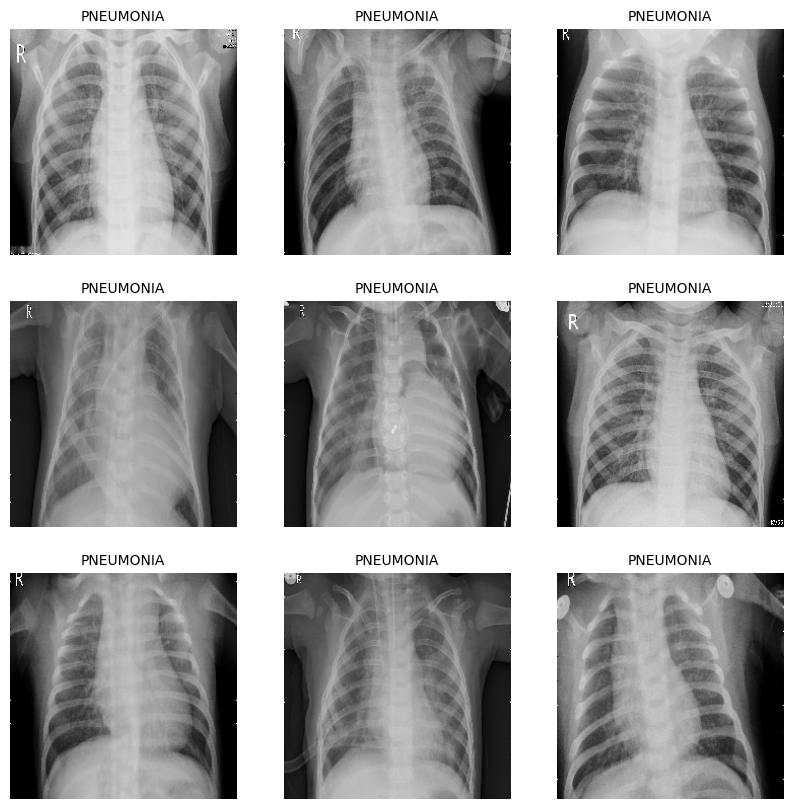

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import os

path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA"
images = os.listdir(path)[:9]

plt.figure(figsize=(10,10))

for i,img_name in enumerate(images):
    img = image.load_img(path + "/" + img_name, target_size=(224,224))
    arr = image.img_to_array(img)/255.0
    pred = model.predict(np.expand_dims(arr,axis=0))[0][0]
    label = "PNEUMONIA" if pred>0.5 else "NORMAL"

    plt.subplot(3,3,i+1)
    plt.imshow(arr)
    plt.title(label,fontsize=10)
    plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


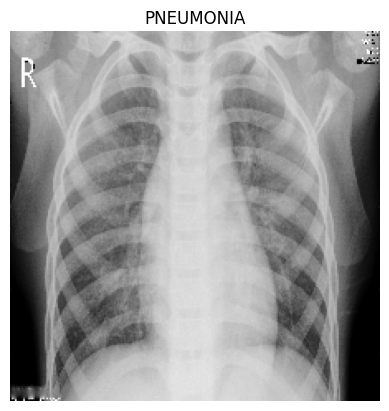

In [14]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/" + files[0]

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_input = np.expand_dims(img_array, axis=0)

pred = model.predict(img_input)[0][0]
label = "PNEUMONIA" if pred > 0.5 else "NORMAL"

plt.imshow(img_array)
plt.title(label)
plt.axis("off")
plt.show()


In [16]:
model.save("model.h5")


In [17]:
!pip install gradio
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

model = tf.keras.models.load_model("/content/model.h5")  # change if your model path is different

def predict(img):
    img = image.smart_resize(img,(224,224))
    arr = np.expand_dims(img/255.0,axis=0)
    pred = model.predict(arr)[0][0]
    label = "PNEUMONIA" if pred>0.5 else "NORMAL"
    confidence = pred*100 if pred>0.5 else (1-pred)*100
    return {label: float(confidence)}

gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=2),
    title="Pneumonia Chest X-Ray Detection"
).launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://97ed70dbf77351b24a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
